# Detector efficiency, effective bandwidth and atmospheric transmission

Plot detector efficiency as function of photon energy and calculate bandwidth, with and without atmospheric absorption.

In [1]:
%pylab inline
import calin.simulation.detector_efficiency
import calin.simulation.atmosphere
import calin.provenance.system_info

Populating the interactive namespace from numpy and matplotlib


### 1 - Get location of calin simulation data files

In [2]:
data_dir = calin.provenance.system_info.build_info().data_install_dir() + "/simulation/"
print("Simulation data directory:",data_dir)

Simulation data directory: /Users/sfegan/local/share/calin/data/simulation/


### 2 - Construct detector efficiency

Combine multiple data files, for PMT quantum efficiency, mirror reflectivity, transmission in plexiglass. Files give efficiency vs wavelength in nm, which are transfomed automatically into curves of efficiency vs photon energy in eV.

In [3]:
det_eff = calin.simulation.detector_efficiency.DetectionEfficiency()
det_eff.scaleEffFromFile(data_dir + 'qe_R12992-100-05.dat')
det_eff.scaleEffFromFile(data_dir + 'ref_AlSiO2HfO2.dat')
det_eff.scaleEffFromFile(data_dir + 'Aclylite8_tra_v2013ref.dat')

### 3 - Load lightcone efficiency

Input from file gives efficiency vs angle to cone entrance normal, which is then tranformed to efficiency vs cos(theta) internally.

In [4]:
cone_eff = calin.simulation.detector_efficiency.AngularEfficiency(data_dir + 'CTA-LST_lightguide_eff.dat')

### 4 - Rescale effective detector and cone efficiencies

Extract the maximum efficiency value for the cone and scale the effective detector efficiency by this value, resetting the cone efficiency to 1.0.

In [5]:
max_cone_eff = max(cone_eff.all_yi())
det_eff.scaleEffByConst(max_cone_eff)
cone_eff.scaleEffByConst(1.0/max_cone_eff)

### 5 - Calculate bandwidth and plot efficiencies

In [6]:
print("Low energy limit:    %.3f eV"%det_eff.xmin())
print("High energy limit:   %.3f eV"%det_eff.xmax())
print("Effective bandwidth: %.3f eV"%det_eff.integrate())

Low energy limit:    1.241 eV
High energy limit:   6.199 eV
Effective bandwidth: 0.620 eV


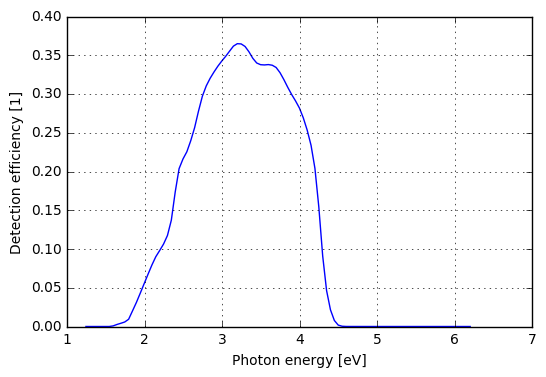

In [7]:
x_eff = frange(det_eff.xmin(),det_eff.xmax(),npts=100,closed=True)
y_eff = asarray(list(map(lambda xx: det_eff.y(xx),x_eff)))
plot(x_eff,y_eff)
xlabel('Photon energy [eV]')
ylabel('Detection efficiency [1]')
grid()

[0.0, 50.0, 0.0, 1.02]

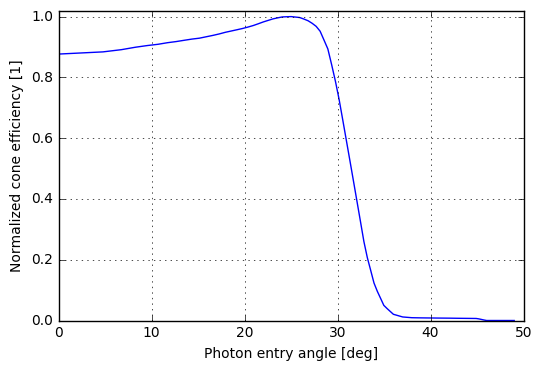

In [8]:
x_cone = frange(cone_eff.xmin(),cone_eff.xmax(),npts=100,closed=True)
y_cone = asarray(list(map(lambda xx: cone_eff.y(xx),x_cone)))
plot(arccos(x_cone)/pi*180,y_cone)
xlabel('Photon entry angle [deg]')
ylabel('Normalized cone efficiency [1]')
grid()
a=list(axis())
a[3]=1.02
axis(a)

### 6 - Load an atmospheric absorption model

In [9]:
atm_abs = calin.simulation.detector_efficiency.AtmosphericAbsorption(data_dir + 'atm_trans_2147_1_10_0_0_2147.dat')

### 7 - Plot transmission and effective Cherenkov "ground" spectrum

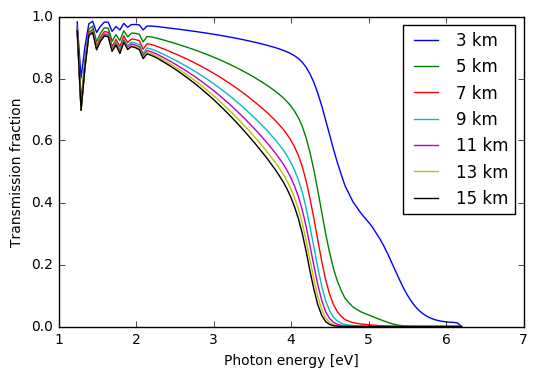

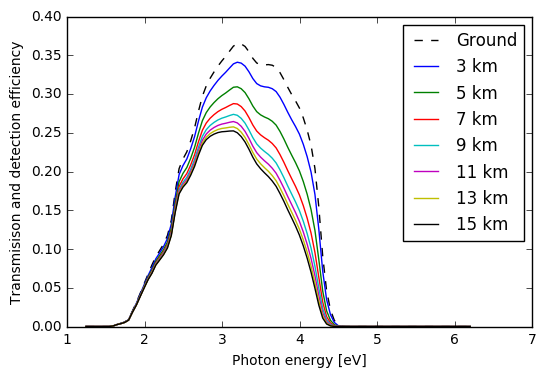

In [10]:
h0 = 2.147
tau0 = atm_abs.opticalDepthForAltitude(h0 * 1e5)
figure(2)
plot(x_eff,y_eff,'k--',label='Ground')#%g km'%(h0/1e3))
for h in frange(3,15.0,2.0):
    tau = atm_abs.opticalDepthForAltitude(h * 1e5) - tau0
    y_abs = asarray(list(map(lambda xx: tau.y(xx),x_eff)))
    figure(1)
    plot(x_eff,exp(-y_abs),label='%g km'%h)
    hold('on')
    figure(2)
    plot(x_eff,exp(-y_abs)*y_eff,label='%g km'%h)
    hold('on')
figure(1)    
xlabel('Photon energy [eV]')
ylabel('Transmission fraction')
legend()
figure(2)
xlabel('Photon energy [eV]')
ylabel('Transmisison and detection efficiency')
legend()

### 8 - Integrate the atmospheric transmission times the detector efficiency

The function "integrateBandwidth" takes a:

1. ground reference level,
2. base zenith angle (or cosine thereof), and
3. detector efficiency

and integrates the total bandwidth for Cherenkov light emitted as a function of height. The object returned allows the bandwidth to be calculated as a function of height and of the true emission (zenith) angle. The height dependency is calculated by interpolation while the angular dependence is calculated from a Taylor expansion around the base value given, which gives good accuracy for a few (5-10) degrees, sufficient for the field of view of all CTA cameras.

In [11]:
zn0 = 35
bandwidth_calc = atm_abs.integrateBandwidth(h0 * 1e5, cos(zn0/180.0*pi), det_eff)

### 9 - Plot total effective bandwidth as function of height for three zenith angles

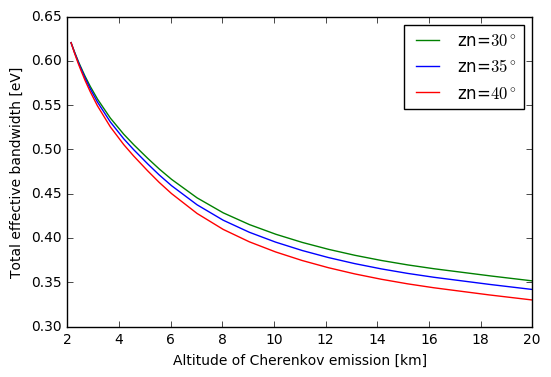

In [12]:
x_bandwidth = frange(h0,20.0,0.01)
y_bandwidth = asarray(list(map(lambda h: bandwidth_calc.bandwidth(h*1e5,cos(zn0/180.0*pi)), x_bandwidth)))
zn1 = zn0+5
y_bandwidth_1 = asarray(list(map(lambda h: bandwidth_calc.bandwidth(h*1e5,cos(zn1/180.0*pi)),  x_bandwidth)))
zn2 = zn0-5
y_bandwidth_2 = asarray(list(map(lambda h: bandwidth_calc.bandwidth(h*1e5,cos(zn2/180.0*pi)),  x_bandwidth)))
plot(x_bandwidth, y_bandwidth_2, 'g', label='zn=$%g^\circ$'%zn2)
plot(x_bandwidth, y_bandwidth, 'b', label='zn=$%g^\circ$'%zn0)
plot(x_bandwidth, y_bandwidth_1, 'r', label='zn=$%g^\circ$'%zn1)
xlabel('Altitude of Cherenkov emission [km]')
ylabel('Total effective bandwidth [eV]')
legend()

### 10 - Load atmospheric profile

In [13]:
#atm = calin.simulation.atmosphere.LayeredAtmosphere.us76()
atm = calin.simulation.atmosphere.LayeredAtmosphere(data_dir + 'atmprof36.dat')

### 11 - Calculate and plot Cherenkov angle

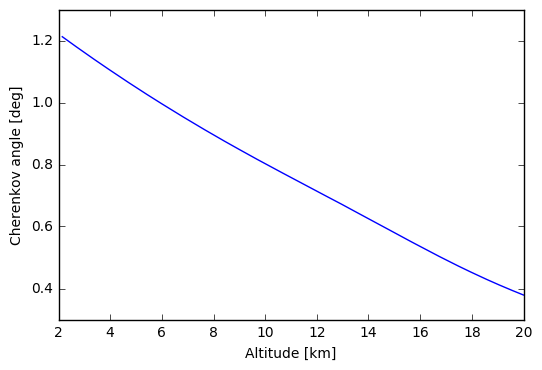

In [14]:
y_n = asarray(list(map(lambda h: 1.0+atm.n_minus_one(h*1e5), x_bandwidth)))
plot(x_bandwidth,arccos(1.0/y_n)/pi*180.0)
xlabel('Altitude [km]')
ylabel('Cherenkov angle [deg]')

### 12 - Calculate and plot propagation delay

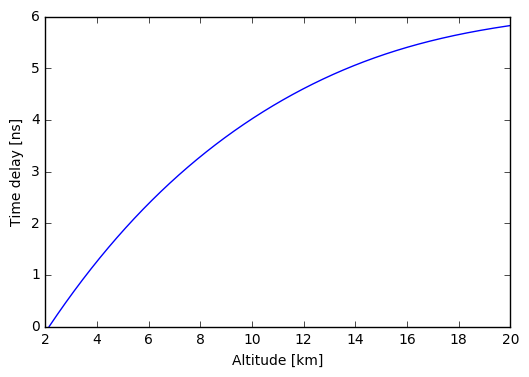

In [15]:
ct0 = atm.propagation_ct_correction(h0*1e5)
y_prop_delay = asarray(list(map(lambda h: atm.propagation_ct_correction(h*1e5)-ct0, x_bandwidth)))
plot(x_bandwidth,y_prop_delay/30) # c = 30 cm/ns
xlabel('Altitude [km]')
ylabel('Time delay [ns]')